<a href="https://colab.research.google.com/github/ariaberlian/rbm_sr/blob/main/rbm_sr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python v3.6.12

##### Run This to Install #####

# ! pip install requirements.txt

## !git clone https://github.com/albertbup/deep-belief-network.git
## !pip install -r "deep-belief-network/requirements.txt"
## !mv "deep-belief-network" "deep_belief_network"

## """
## - add this to dbn/tensorflow/models.py:
##     import tensorflow._api.v2.compat.v1 as tf
##     tf.disable_v2_behavior()
## """

In [2]:
from deep_belief_network.dbn.tensorflow.models import UnsupervisedDBN # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow
from utils.data_processing import DataProcessing
from utils.image_file_util import *
from utils.scoring import *
from utils.visualizer import *
import tracemalloc

c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages

## DBN

In [3]:
## Training DBN
def train(model, input : np.ndarray, model_name : str, repetitions: int, beta:float, interpolation_factor:float):
    dp = DataProcessing()

    visualize_histogram(input, title=f"Training Image")

    curr_rep = 1
    print("Repetisi saat ini: ", curr_rep)

    model.fit(input)
    model.save(f"model/{model_name}_{curr_rep}.h5")

    while curr_rep < repetitions:
        model = model.load(f"model/{model_name}_{curr_rep}.h5")
        r = model.transform(input)
        print("Shape Transformed: ", r.shape)
        input = dp.proccess_output(u=input, r=r, beta=beta, s=interpolation_factor)
        visualize_histogram(input, title=f"Training Image: After transform ({curr_rep})")
        r = None

        curr_rep += 1
        print("Repetisi saat ini: ", curr_rep )

        model.fit(input)
        model.save(f"model/{model_name}_{curr_rep}.h5")

## Test DBN
def test(test_image, test_reference_image, model, patch_size:tuple, stride:tuple, interpolation_factor:int):
    dp = DataProcessing()

    desired_shape = test_reference_image.shape
    
    test_image = dp.interpolate(test_image, interpolation_factor=interpolation_factor)
    
    visualize_image(test_image, title="Test Image after interpolation")
    visualize_histogram(test_image, title="Test Image after interpolation", range=(0,256))
    psnr_baseline_value = calculate_psnr(test_reference_image, test_image)
    ssim_baseline_value = calculate_ssim(test_reference_image, test_image)*100

    psnr_print = f"PSNR Baseline value: {psnr_baseline_value:,.3f} dB"
    ssim_print = f"SSIM Baseline value: {ssim_baseline_value:,.3f}%"
    print(psnr_print.replace(".", ","))
    print(ssim_print.replace(".", ","))

    test_patches = dp.get_patches(test_image,patch_size=patch_size, stride=stride)

    # Process data for rbm
    test_patches = dp.preprocess_for_rbm(test_patches)

    # Infer test to model
    result = model.transform(test_patches)

    test_patches = dp.inverse_preprocess(
        dp.proccess_output(test_patches, result, 1, interpolation_factor),
        original_patch_shape=(patch_size[0], patch_size[1], 3)
        )
    
    result = None

    visualize_patches(test_patches, title="Test Patches Example", visualize_size=(6,6))

    reconstruct_image = dp.reconstruct_from_patches(test_patches, original_shape=desired_shape, patch_size=patch_size, stride=stride)

    test_patches = None

    visualize_histogram_compare(original_image=test_reference_image, reconstruct_image=reconstruct_image)
    psnr_value = calculate_psnr(test_reference_image, reconstruct_image)
    ssim_value = calculate_ssim(test_reference_image, reconstruct_image)*100

    psnr_print = f"PSNR value: {psnr_value:,.3f} dB"
    ssim_print = f"SSIM value: {ssim_value:,.3f}%"

    print(psnr_print.replace(".", ","))
    print(ssim_print.replace(".", ","))


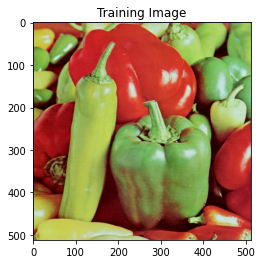

Jumlah Patches =  15625


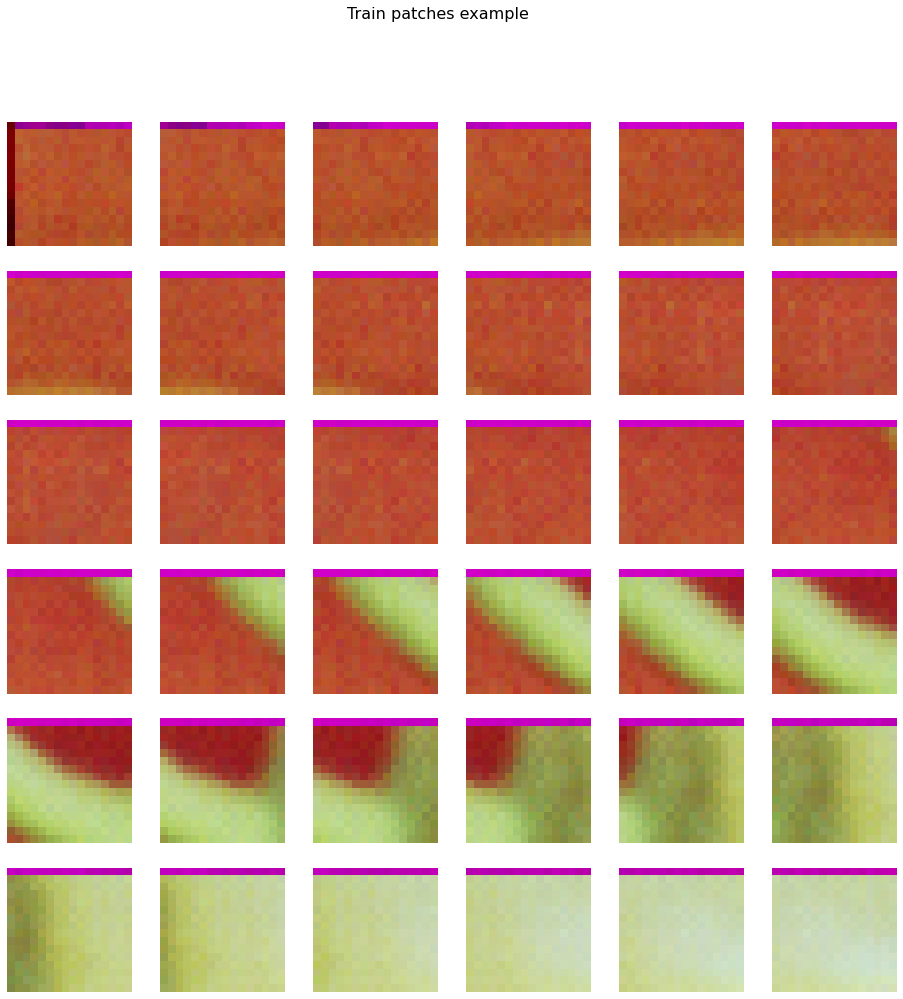

DCT coefficients shape:  (15625, 16, 16, 3)
[ Top 10 differences in memory allocation ]
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\tracemalloc.py:387: size=592 B (+592 B), count=4 (+4), average=148 B
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\tracemalloc.py:524: size=568 B (+568 B), count=3 (+3), average=189 B
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\codeop.py:133: size=574 B (+256 B), count=8 (+4), average=72 B
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\contextlib.py:63: size=144 B (+72 B), count=2 (+1), average=72 B
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\tracemalloc.py:279: size=56 B (+56 B), count=1 (+1), average=56 B
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\tracemalloc.py:281: size=40 B (+40 B), count=1 (+1), average=40 B
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\numpy\core\_asarray.py:83: size=92.0 MiB (+0 B), count=6993 (+0), average=13.5 KiB
c:\Users\Aria Berlian\.conda\envs\rbm_sr\lib\site-packages\matplotlib\lines.py:366: size=3260 KiB (+0 

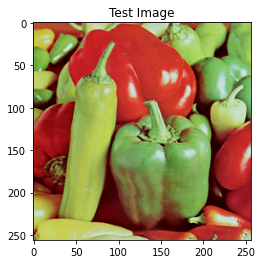

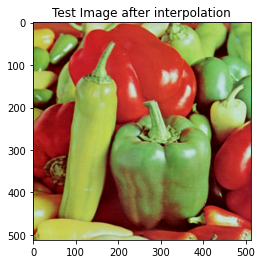

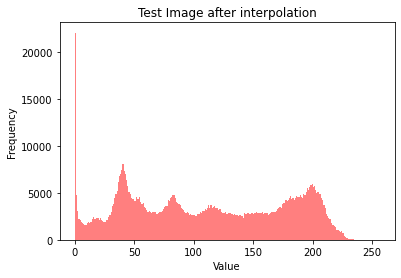

PSNR Baseline value: 28,794 dB
SSIM Baseline value: 83,211%
Jumlah Patches =  15625
DCT coefficients shape:  (15625, 16, 16, 3)
Denormalized coeffients array shape:  (15625, 16, 16, 3)


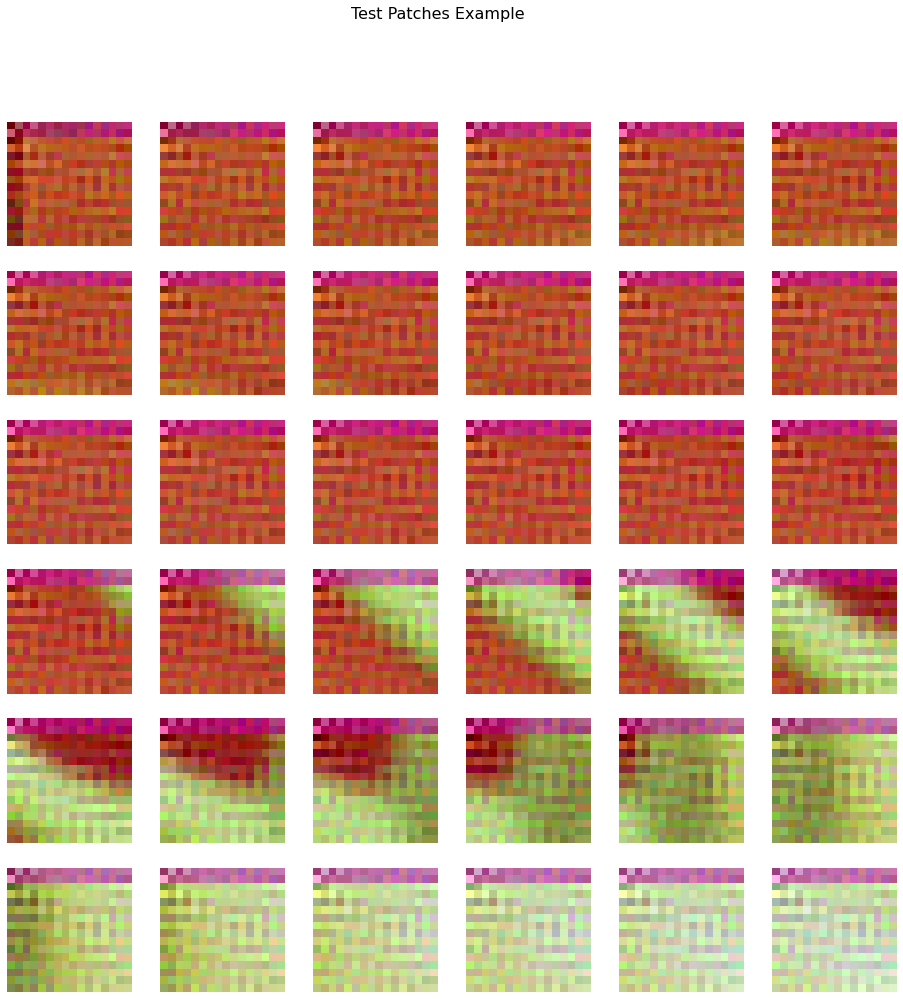

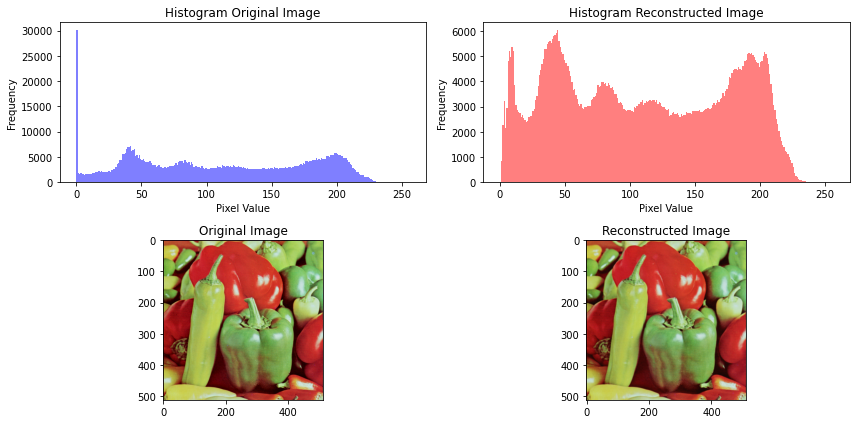

PSNR value: 28,038 dB
SSIM value: 72,447%
== Test 2 ==


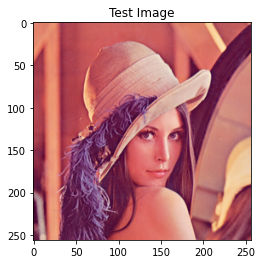

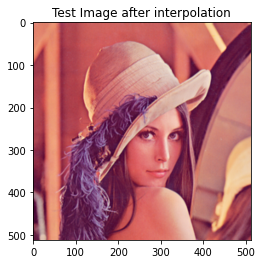

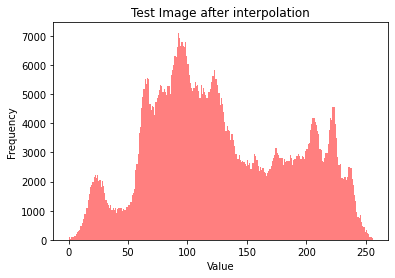

PSNR Baseline value: 30,846 dB
SSIM Baseline value: 86,966%
Jumlah Patches =  15625
DCT coefficients shape:  (15625, 16, 16, 3)
Denormalized coeffients array shape:  (15625, 16, 16, 3)


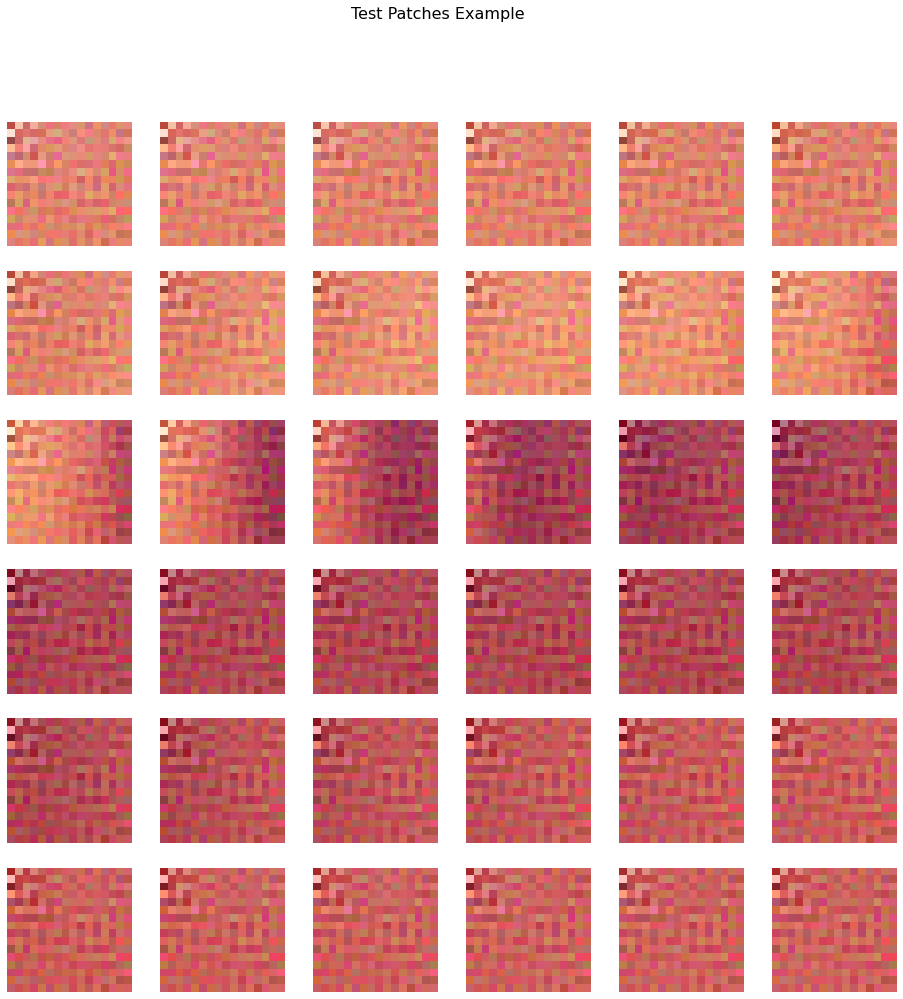

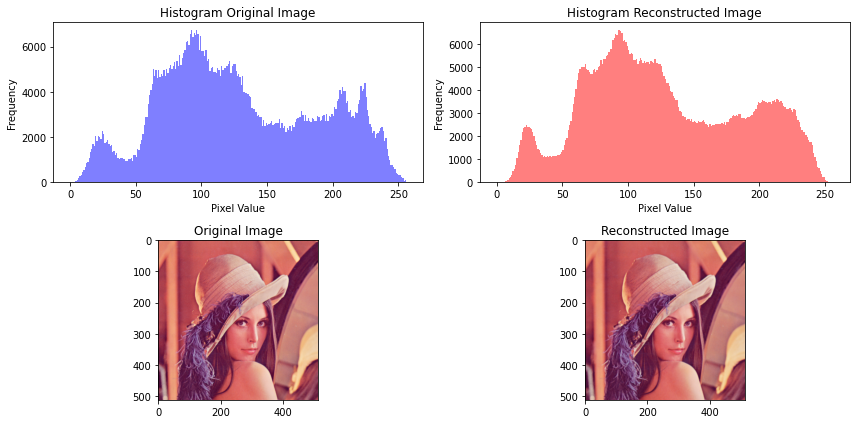

PSNR value: 30,125 dB
SSIM value: 78,955%


In [4]:
tracemalloc.start()

#### Patch size and Stride ####
patch_size = (16,16)
stride = (4,4)

#### Load Data ####
train_resolution = 512
test_resolution = 256

dp = DataProcessing()

# Load Training Data
training_image = load_image("train/peppers.png")
visualize_image(training_image, "Training Image")

train_patches = dp.get_patches(training_image, patch_size=patch_size, stride=stride)

# Feel free to reduce training set
training_set_num = train_patches.shape[0]

visualize_patches(train_patches, "Train patches example")


X_train = dp.preprocess_for_rbm(train_patches[:training_set_num])

train_patches = None
training_image = None

#### Training parameter ###
interpolation_factor = 2
beta = 1
Repetitions = 1
lr = 0.01
epoch = 100

layers = [400,200,768]
batch_size = 1024
activation_function = 'sigmoid'

model_name = f"model_peppers_{train_resolution}_x{interpolation_factor}_p{patch_size[0]}_s{stride[0]}_({layers[0]}_{layers[1]}_{layers[2]})"

# Models we will use
dbn = UnsupervisedDBN(hidden_layers_structure=layers,
                      batch_size=batch_size,
                      learning_rate_rbm=lr,
                      n_epochs_rbm=epoch,
                      activation_function=activation_function,
                      optimization_algorithm='sgd',)

#### Train and Test ####

snapshot1 = tracemalloc.take_snapshot()

# comment this to skip training
train(
    model=dbn, 
    input=X_train, 
    model_name=model_name,
    beta=beta,
    interpolation_factor=interpolation_factor,
    repetitions=Repetitions, 
)

snapshot2 = tracemalloc.take_snapshot()
top_stats = snapshot2.compare_to(snapshot1, 'lineno')

print("[ Top 10 differences in memory allocation ]")
for stat in top_stats[:10]:
    print(stat)

# Load Testing Data
print("== Test 1 ==")
test_image = load_image(f"test/peppers_256.png")
visualize_image(test_image, title="Test Image")

test_reference_image = load_image(f"train/peppers.png")
dbn = dbn.load(f"model/{model_name}_{Repetitions}.h5")

test(
    test_image=test_image,
    test_reference_image=test_reference_image,
    model=dbn,
    patch_size=patch_size,
    stride=stride,
    interpolation_factor=interpolation_factor
)

print("== Test 2 ==")
test_image = load_image(f"test/lenna_256.png")
visualize_image(test_image, title="Test Image")

test_reference_image = load_image(f"train/lenna.png")
dbn = dbn.load(f"model/{model_name}_{Repetitions}.h5")

test(
    test_image=test_image,
    test_reference_image=test_reference_image,
    model=dbn,
    patch_size=patch_size,
    stride=stride,
    interpolation_factor=interpolation_factor
)

# print("== Test 3 ==")
# test_image = load_image(f"test/{test_resolution}/ct_lung4_{test_resolution}.png")
# visualize_image(test_image, title="Test Image")

# test_reference_image = load_image(f"test/{train_resolution}/ct_lung4_{train_resolution}.png")
# dbn = dbn.load(f"model/{model_name}_{Repetitions}.h5")

# test(
#     test_image=test_image,
#     test_reference_image=test_reference_image,
#     model=dbn,
#     patch_size=patch_size,
#     stride=stride,
#     interpolation_factor=interpolation_factor
# )